<a href="https://colab.research.google.com/github/torigrosskopf/deep-learning/blob/main/OpenFold_EGFR_Binder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Running OpenFold to Generate an Optimized Structure of an EGFR Binder

Source code from [aqlaboratory](https://https://github.com/aqlaboratory/openfold/blob/main/notebooks/OpenFold.ipynb) on GitHub.

In this notebook, the model will be run with OpenFold parameters in monomer mode (classification of EGFR protein).

The first cell of this notebook takes the previously generated sequence as input, and initializes parameters for the protein design model. It preprocesses the input sequence if necessary.

In [1]:
# Enter in amino acid sequence to fold

input_sequence = 'SEEEEERERALKEIIEETRRELKAAKAKHGKVVVVLIMASSTLEPEFILELSKALIKEMKSLFPNVVLIIVVVGLAPASLLARIRDVSLELAKYAKSLGIKVIVIVGNENEAVFVPAFEALGVEVIVDRTIIEIAAEELGLSEEEVLARFAAAAELLDELFAADPSLRERYARLDVAGATELLLERLRELFGAKVERHERLITVEVERVLTPDERRRVTAILLTPEAAREVVERLVDLVVDLILEKIAEGHNVLVLVFTPTIALAREVAALFEERRPLLEEAGAAVIIRLVARDPDTFLI'  #@param {type:"string"}

# Configure model to be in monomer mode with OpenFold parameters

weight_set = 'OpenFold' #@param ["OpenFold", "AlphaFold"]
model_mode = 'monomer' #@param ["monomer", "multimer"]
relax_prediction = True #@param {type:"boolean"}

# Remove all whitespaces, tabs and end lines; upper-case
input_sequence = input_sequence.translate(str.maketrans('', '', ' \n\t')).upper()
aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
allowed_chars = aatypes.union({':'})
if not set(input_sequence).issubset(allowed_chars):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(input_sequence) - allowed_chars}. OpenFold only supports 20 standard amino acids as inputs.')

if ':' in input_sequence and weight_set != 'AlphaFold':
  raise ValueError('Input sequence is a multimer, must select Alphafold weight set')

import enum

@enum.unique
class ModelType(enum.Enum):
  MONOMER = 0
  MULTIMER = 1

model_type_dict = {
    'monomer': ModelType.MONOMER,
    'multimer': ModelType.MULTIMER,
}

model_type = model_type_dict[model_mode]
print(f'Length of input sequence : {len(input_sequence.replace(":", ""))}')

Length of input sequence : 300


### Importing Third-Party Software

The following cell installs the necessary software on the Colab notebook in the cloud to eliminate the need to create an external conda environment on personal device.

In [2]:
# Import third-party software


import os, time
from IPython.utils import io
from sys import version_info
import subprocess

python_version = f"{version_info.major}.{version_info.minor}"


os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
os.system("mamba config --set auto_update_conda false")
os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python={python_version} pdbfixer biopython=1.83")
os.system("pip install -q torch ml_collections py3Dmol modelcif")

try:
  with io.capture_output() as captured:

    # Create a ramdisk to store a database chunk to make Jackhmmer run fast.
    %shell sudo apt install --quiet --yes hmmer
    %shell sudo mkdir -m 777 --parents /tmp/ramdisk
    %shell sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk

    %shell wget -q -P /content \
      https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt

    %shell mkdir -p /content/openfold/openfold/resources

    commit = "3bec3e9b2d1e8bdb83887899102eff7d42dc2ba9"
    os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

    os.system(f"cp -f -p /content/stereo_chemical_props.txt /usr/local/lib/python{python_version}/site-packages/openfold/resources/")

except subprocess.CalledProcessError as captured:
  print(captured)

### Downloading Model Weights

The following cell installs established model weights for both AlphaFold2 and OpenFold from their respective sources.

In [3]:
# Download model weights

# Define constants
GIT_REPO='https://github.com/aqlaboratory/openfold'
ALPHAFOLD_PARAM_SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar'
OPENFOLD_PARAMS_DIR = './openfold/openfold/resources/openfold_params'
ALPHAFOLD_PARAMS_DIR = './openfold/openfold/resources/params'
ALPHAFOLD_PARAMS_PATH = os.path.join(
  ALPHAFOLD_PARAMS_DIR, os.path.basename(ALPHAFOLD_PARAM_SOURCE_URL)
)

try:
  with io.capture_output() as captured:
    if(weight_set == 'AlphaFold'):
      %shell mkdir --parents "{ALPHAFOLD_PARAMS_DIR}"
      %shell wget -O {ALPHAFOLD_PARAMS_PATH} {ALPHAFOLD_PARAM_SOURCE_URL}
      %shell tar --extract --verbose --file="{ALPHAFOLD_PARAMS_PATH}" \
        --directory="{ALPHAFOLD_PARAMS_DIR}" --preserve-permissions
      %shell rm "{ALPHAFOLD_PARAMS_PATH}"
    elif(weight_set == 'OpenFold'):
      # Install AWS CLI
      %shell curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
      %shell unzip -qq awscliv2.zip
      %shell sudo ./aws/install
      %shell rm awscliv2.zip
      %shell rm -rf ./aws
      %shell mkdir --parents "{OPENFOLD_PARAMS_DIR}"

      %shell aws s3 cp \
        --no-sign-request \
        --region us-east-1 \
        s3://openfold/openfold_params "{OPENFOLD_PARAMS_DIR}" \
        --recursive
    else:
      raise ValueError("Invalid weight set")
except subprocess.CalledProcessError as captured:
  print(captured)


In [4]:
# Import necessary python packages
import unittest.mock
import sys
from typing import Dict, Sequence

sys.path.insert(0, f'/usr/local/lib/python{python_version}/dist-packages/')
sys.path.insert(0, f'/usr/local/lib/python{python_version}/site-packages/')

# Allows us to skip installing these packages
unnecessary_modules = [
  "dllogger",
  "pytorch_lightning",
  "pytorch_lightning.utilities",
  "pytorch_lightning.callbacks.early_stopping",
  "pytorch_lightning.utilities.seed",
]
for unnecessary_module in unnecessary_modules:
  sys.modules[unnecessary_module] = unittest.mock.MagicMock()

import os

from urllib import request
from concurrent import futures
from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import torch
import shutil
import tqdm
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

# Prevent shell magic being broken by openmm, prevent this cryptic error:
# "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968"
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

from openfold import config
from openfold.data import feature_pipeline
from openfold.data import parsers
from openfold.data import data_pipeline
from openfold.data import msa_pairing
from openfold.data import feature_processing_multimer
from openfold.data.tools import jackhmmer
from openfold.model import model
from openfold.np import protein
from openfold.np.relax import relax
from openfold.np.relax.utils import overwrite_b_factors
from openfold.utils.import_weights import import_jax_weights_, import_openfold_weights_
from openfold.utils.tensor_utils import tensor_tree_map

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output


### Preprocessing Data for Making a Prediction

The next section of code takes the input sequence of our binder and runs a search against genetic databases. This cell will show statistics about multiple sequence alignment (MSA) used by OpenFold. Specifically, how well each residue of our sequence is covered by similar sequences in the MSA. It also prepares MSAs for downstream analysis by OpenFold.

  0%|          | 0/199 [elapsed: 00:00 remaining: ?]

parsing_results_for_sequence SEEEEERERALKEIIEETRRELKAAKAKHGKVVVVLIMASSTLEPEFILELSKALIKEMKSLFPNVVLIIVVVGLAPASLLARIRDVSLELAKYAKSLGIKVIVIVGNENEAVFVPAFEALGVEVIVDRTIIEIAAEELGLSEEEVLARFAAAAELLDELFAADPSLRERYARLDVAGATELLLERLRELFGAKVERHERLITVEVERVLTPDERRRVTAILLTPEAAREVVERLVDLVVDLILEKIAEGHNVLVLVFTPTIALAREVAALFEERRPLLEEAGAAVIIRLVARDPDTFLI
35 Sequences Found in smallbfd
7 Sequences Found in mgnify
38 Sequences Found in uniref90

50 Sequences Found in Total



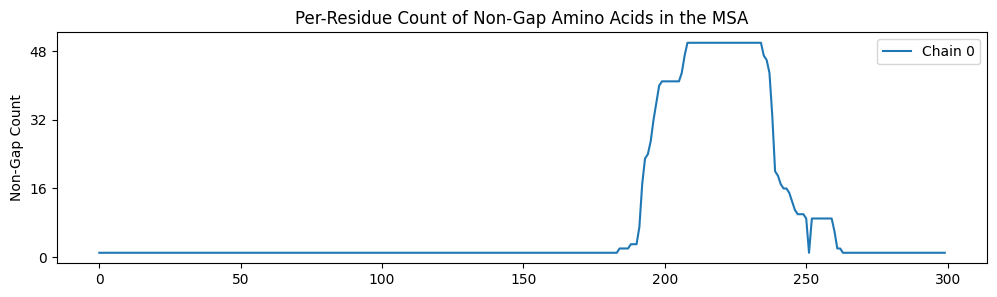

In [5]:
# Search against genetic databases

# --- Find the closest source --
test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
ex = futures.ThreadPoolExecutor(3)
def fetch(source):
  request.urlretrieve(test_url_pattern.format(source))
  return source
fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
source = None
for f in futures.as_completed(fs):
  source = f.result()
  ex.shutdown()
  break

# Run the search against chunks of genetic databases (since the genetic databases don't fit in Colab ramdisk).

# jackhmmer performs multiple rounds of searching and builds an HMM profile based on the input sequence.
# Used to identify evolutionarily related sequences (homologs), which can be important for understanding
# structure prediction.

jackhmmer_binary_path = '/usr/bin/jackhmmer'

# --- Parse multiple sequences, if there are any ---
def split_multiple_sequences(sequence):
  seqs = sequence.split(':')
  sorted_seqs = sorted(seqs, key=lambda s: len(s))

  # Handle the homomer case when writing fasta sequences

  fasta_path_tuples = []
  for idx, seq in enumerate(set(sorted_seqs)):
    fasta_path = f'target_{idx+1}.fasta'
    with open(fasta_path, 'wt') as f:
      f.write(f'>query\n{seq}\n')
    fasta_path_tuples.append((seq, fasta_path))
  fasta_path_by_seq = dict(fasta_path_tuples)

  return sorted_seqs, fasta_path_by_seq

sequences, fasta_path_by_sequence = split_multiple_sequences(input_sequence)
db_results_by_sequence = {seq: {} for seq in fasta_path_by_sequence.keys()}

# Import datasets for MSA extraction
DB_ROOT_PATH = f'https://storage.googleapis.com/alphafold-colab{source}/latest/'
db_configs = {}
db_configs['smallbfd'] = {
    'database_path': f'{DB_ROOT_PATH}uniref90_2021_03.fasta',
    'z_value': 65984053,
    'num_jackhmmer_chunks': 17,
}
db_configs['mgnify'] = {
    'database_path': f'{DB_ROOT_PATH}mgy_clusters_2022_05.fasta',
    'z_value': 304820129,
    'num_jackhmmer_chunks': 120,
}
db_configs['uniref90'] = {
     'database_path': f'{DB_ROOT_PATH}uniref90_2022_01.fasta',
     'z_value': 144113457,
     'num_jackhmmer_chunks': 62,
}

# Search UniProt and construct the all_seq features only for heteromers, not homomers.
# Homomers have limited functional variability due to identical subunits.
# Goal here is to prioritize biologically relevant and comoutationally efficient analysis.

if model_type == ModelType.MULTIMER and len(set(sequences)) > 1:
  db_configs['uniprot'] = {
       'database_path': f'{DB_ROOT_PATH}uniprot_2021_04.fasta',
       'z_value': 225013025 + 565928,
       'num_jackhmmer_chunks': 101,
       }

# Format progress bar
total_jackhmmer_chunks = sum([d['num_jackhmmer_chunks'] for d in db_configs.values()])
with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
  def jackhmmer_chunk_callback(i):
    pbar.update(n=1)

  for db_name, db_config in db_configs.items():
    pbar.set_description(f'Searching {db_name}')
    jackhmmer_runner = jackhmmer.Jackhmmer(
        binary_path=jackhmmer_binary_path,
        database_path=db_config['database_path'],
        get_tblout=True,
        num_streamed_chunks=db_config['num_jackhmmer_chunks'],
        streaming_callback=jackhmmer_chunk_callback,
        z_value=db_config['z_value'])

    db_results = jackhmmer_runner.query_multiple(fasta_path_by_sequence.values())
    for seq, result in zip(fasta_path_by_sequence.keys(), db_results):
      db_results_by_sequence[seq][db_name] = result

# NB: deduplication happens later in data_pipeline.make_msa_features.

# Define max # of hits for each database
MAX_HITS_BY_DB = {
    'uniref90': 10000,
    'smallbfd': 5000,
    'mgnify': 501,
    'uniprot': 50000,
}

# Store MSAs in two dictionaries
msas_by_seq_by_db = {seq: {} for seq in sequences} # MSAs organized by sequence and database
full_msa_by_seq = {seq: [] for seq in sequences} # Combined MSAs across databases for each sequence

# Extract MSAs from Stockholm files and organize by sequence / database
# Filter and sort MSAs based on their e-values (alignment significance)
for seq, sequence_result in db_results_by_sequence.items():
  print(f'parsing_results_for_sequence {seq}')
  for db_name, db_results in sequence_result.items():
    unsorted_results = []
    for i, result in enumerate(db_results):
      msa_obj = parsers.parse_stockholm(result['sto'])
      e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
      target_names = msa_obj.descriptions
      e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
      zipped_results = zip(msa_obj.sequences, msa_obj.deletion_matrix, target_names, e_values)
      if i != 0:
        # Only take query from the first chunk
        zipped_results = [x for x in zipped_results if x[2] != 'query']
      unsorted_results.extend(zipped_results)
    sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
    msas, del_matrix, targets, _ = zip(*sorted_by_evalue)
    db_msas = parsers.Msa(msas, del_matrix, targets)

    # Truncate MSAs to predefined max # of hits for each database
    if db_msas:
      if db_name in MAX_HITS_BY_DB:
        db_msas.truncate(MAX_HITS_BY_DB[db_name])
      msas_by_seq_by_db[seq][db_name] = db_msas
      full_msa_by_seq[seq].extend(db_msas.sequences)
      msa_size = len(set(db_msas.sequences))
      print(f'{msa_size} Sequences Found in {db_name}')

# Display results of search:
  # Show the number of sequences found in each dataset
  # For monomer mode, the sets are smallbfd, mgnify, and uniref90
  # Plot per-residue count of non-gap amino acids in the MSA

fig = plt.figure(figsize=(12, 3))
max_num_alignments = 0

for seq_idx, seq in enumerate(set(sequences)):
  full_msas = full_msa_by_seq[seq]
  deduped_full_msa = list(dict.fromkeys(full_msas))
  total_msa_size = len(deduped_full_msa)
  print(f'\n{total_msa_size} Sequences Found in Total\n')

  aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
  msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
  num_alignments, num_res = msa_arr.shape
  plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), label=f'Chain {seq_idx}')
  max_num_alignments = max(num_alignments, max_num_alignments)

plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, max_num_alignments + 1, max(1, int(max_num_alignments / 3))))
plt.legend()
plt.show()


### Running OpenFold and Generating Structure Prediction

The final section of this notebook takes the input features (sequences and MSAs) and processes them for the model. The pre-trained OpenFold model is then configured and loaded. Data is then processed by the model to generate a structure prediction. Finally, the prediction is evaluated by computing pLDDT confidence scores.

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

<ipython-input-6-bb801090c7d4>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(params_name)


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

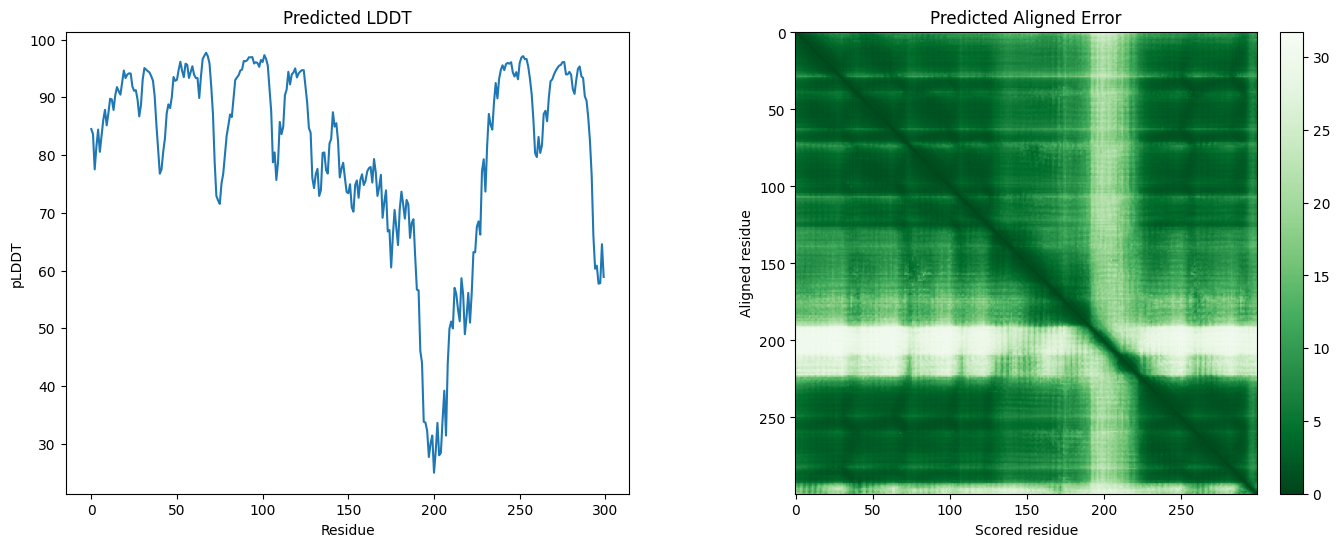

In [6]:
# Run OpenFold and download prediction

# Color bands for visualizing plddt
PLDDT_BANDS = [
  (0, 50, '#FF7D45'),
  (50, 70, '#FFDB13'),
  (70, 90, '#65CBF3'),
  (90, 100, '#0053D6')
]

# --- Run the model ---

# Import model checkpoints (pre-trained / fine-tuned model weights)
if model_type == ModelType.MONOMER:
  model_names = [
   'finetuning_3.pt',
   'finetuning_4.pt',
   'finetuning_5.pt',
   'finetuning_ptm_2.pt',
   'finetuning_no_templ_ptm_1.pt'
  ]
elif model_type == ModelType.MULTIMER:
  model_names = [
    'model_1_multimer_v3',
    'model_2_multimer_v3',
    'model_3_multimer_v3',
    'model_4_multimer_v3',
    'model_5_multimer_v3',
  ]

# Template feature placeholder function:
  # Generates empty or placeholder arrays to represent features when templates are not being used
def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros((num_templates_, num_res_, 22), dtype=np.int64),
      'template_all_atom_positions': np.zeros((num_templates_, num_res_, 37, 3), dtype=np.float32),
      'template_all_atom_mask': np.zeros((num_templates_, num_res_, 37), dtype=np.float32),
      'template_domain_names': np.zeros((num_templates_,), dtype=np.float32),
      'template_sum_probs': np.zeros((num_templates_, 1), dtype=np.float32),
  }

# Process sequences, MSAs, and other features required to generate input required by model
def make_features(
    sequences: Sequence[str],
    msas_by_seq_by_db: Dict[str, Dict[str, parsers.Msa]],
    model_type: ModelType):
  num_templates = 1 # Placeholder for generating fake template features
  feature_dict = {}

  for idx, seq in enumerate(sequences, start=1):
    _chain_id = f'chain_{idx}'
    num_res = len(seq)

    feats = data_pipeline.make_sequence_features(seq, _chain_id, num_res)
    msas_without_uniprot = [msas_by_seq_by_db[seq][db] for db in db_configs.keys() if db != 'uniprot']
    msa_feats = data_pipeline.make_msa_features(msas_without_uniprot)
    feats.update(msa_feats)
    feats.update(_placeholder_template_feats(num_templates, num_res))

    # Produce dictionary of sequences for each sequence (MONOMER) or chain (MULTIMER)
    if model_type == ModelType.MONOMER:
      feature_dict[seq] = feats
    if model_type == ModelType.MULTIMER:
      # Perform extra pair processing steps for heteromers
      if len(set(sequences)) > 1:
        uniprot_msa = msas_by_seq_by_db[seq]['uniprot']
        uniprot_msa_features = data_pipeline.make_msa_features([uniprot_msa])
        valid_feat_names = msa_pairing.MSA_FEATURES + (
                'msa_species_identifiers',
            )
        pair_feats = {
                f'{k}_all_seq': v for k, v in uniprot_msa_features.items()
                if k in valid_feat_names
            }
        feats.update(pair_feats)

      feats = data_pipeline.convert_monomer_features(feats, _chain_id)
      feature_dict[_chain_id] = feats

  if model_type == ModelType.MONOMER:
    np_example = feature_dict[sequences[0]]
  elif model_type == ModelType.MULTIMER:
    all_chain_feats = data_pipeline.add_assembly_features(feature_dict)
    features = feature_processing_multimer.pair_and_merge(all_chain_features=all_chain_feats)
    np_example = data_pipeline.pad_msa(features, 512)


  return np_example


output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

# Initialize dictionaries to store outputs
plddts = {}
pae_outputs = {}
weighted_ptms = {}
unrelaxed_proteins = {}

# Format progress bar
with tqdm.notebook.tqdm(total=len(model_names), bar_format=TQDM_BAR_FORMAT) as pbar:
  # Loop through models
  for i, model_name in enumerate(model_names, start = 1):
    pbar.set_description(f'Running {model_name}')

    # Generate model-specific configurations with make_features function
    feature_dict = make_features(sequences, msas_by_seq_by_db, model_type)

    # Determine model configuratioon based on weight set and model type
    if(weight_set == "AlphaFold"):
      if model_type == ModelType.MONOMER:
        config_preset = f"model_{i}"
      elif model_type == ModelType.MULTIMER:
        config_preset = f'model_{i}_multimer_v3'
    else:
      if("_no_templ_" in model_name):
        config_preset = "model_3"
      else:
        config_preset = "model_1"
      if("_ptm_" in model_name):
        config_preset += "_ptm"

    # Load model parameters
    cfg = config.model_config(config_preset)

    # Force the model to only use 3 recycling updates
    cfg.data.common.max_recycling_iters = 3
    cfg.model.recycle_early_stop_tolerance = -1

    openfold_model = model.AlphaFold(cfg)
    openfold_model = openfold_model.eval()
    if(weight_set == "AlphaFold"):
      params_name = os.path.join(
        ALPHAFOLD_PARAMS_DIR, f"params_{config_preset}.npz"
      )
      import_jax_weights_(openfold_model, params_name, version=config_preset)
    elif(weight_set == "OpenFold"):
      params_name = os.path.join(
        OPENFOLD_PARAMS_DIR,
        model_name,
      )
      d = torch.load(params_name)
      import_openfold_weights_(model=openfold_model, state_dict=d)
    else:
      raise ValueError(f"Invalid weight set: {weight_set}")


    openfold_model = openfold_mode

    # Process features for prediction
    pipeline = feature_pipeline.FeaturePipeline(cfg.data)
    processed_feature_dict = pipeline.process_features(
      feature_dict,
      mode='predict',
      is_multimer = (model_type == ModelType.MULTIMER),
        )

    # Move data to GPU to speed up inference
    processed_feature_dict = tensor_tree_map(
        lambda t: t.cuda(), processed_feature_dict
    )
    # Perform inference
    # torch.no_grad() ensures that no unnecessary memory is allocated for gradient computations
    with torch.no_grad():
      prediction_result = openfold_model(processed_feature_dict)

    # Move the batch and output to np for further processing
    # Moves tensors back from GPU to CPU and converts them to NumPy arrays
    processed_feature_dict = tensor_tree_map(
      lambda t: np.array(t[..., -1].cpu()), processed_feature_dict
    )
    prediction_result = tensor_tree_map(
      lambda t: np.array(t.cpu()), prediction_result
    )

    # Compute pLDDT values
    mean_plddt = prediction_result['plddt'].mean()


    # Process results of predictions for each type of model
    if model_type == ModelType.MONOMER:
      # Conditional handling
      if 'predicted_aligned_error' in prediction_result:
        pae_outputs[model_name] = (
            prediction_result['predicted_aligned_error'],
            prediction_result['max_predicted_aligned_error']
        )
      else:
        # Get the pLDDT confidence metrics. Do not put pTM models here as they
        # should never get selected.
        plddts[model_name] = prediction_result['plddt']
    elif model_type == ModelType.MULTIMER:
      # Multimer models are sorted by pTM+ipTM.
      plddts[model_name] = prediction_result['plddt']
      pae_outputs[model_name] = (prediction_result['predicted_aligned_error'],
                                 prediction_result['max_predicted_aligned_error'])




      weighted_ptms[model_name] = prediction_result['weighted_ptm_score']

    # Set the b-factors to the per-residue plddt.
    # Generate protein object from prediction results and processed input features. Store in dictionary.
    final_atom_mask = prediction_result['final_atom_mask']
    b_factors = prediction_result['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(
      processed_feature_dict,
      prediction_result,
      remove_leading_feature_dimension=False,
      b_factors=b_factors,
    )
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del openfold_model
    del processed_feature_dict
    del prediction_result
    pbar.update(n=1)

  # Find the best model according to the mean pLDDT.
  if model_type == ModelType.MONOMER:
    best_model_name = max(plddts.keys(), key=lambda x: plddts[x].mean())
  elif model_type == ModelType.MULTIMER:
    best_model_name = max(weighted_ptms.keys(), key=lambda x: weighted_ptms[x])
  best_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])



  # --- AMBER relax the best model ---
  # Refines atomic positions to reduce structural strains and improve geometry
  # Updates and replaces unrelaxed best_pdb
  if(relax_prediction):
    pbar.set_description(f'AMBER relaxation')
    amber_relaxer = relax.AmberRelaxation(
        max_iterations=0,
        tolerance=2.39,
        stiffness=10.0,
        exclude_residues=[],
        max_outer_iterations=20,
        use_gpu=True,
    )
    relaxed_pdb, _, _ = amber_relaxer.process(
        prot=unrelaxed_proteins[best_model_name]
    )
    best_pdb = relaxed_pdb

  # Write out the prediction
  pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
  with open(pred_output_path, 'w') as f:
    f.write(best_pdb)

  pbar.update(n=1)  # Finished AMBER relax.


# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = overwrite_b_factors(best_pdb, banded_b_factors)

# --- Visualise the prediction & confidence ---
show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = [
            'Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt


# Show the structure coloured by chain if the multimer model has been used.
if model_type == ModelType.MULTIMER:
  multichain_view = py3Dmol.view(width=800, height=600)
  multichain_view.addModelsAsFrames(to_visualize_pdb)
  multichain_style = {'cartoon': {'colorscheme': 'chain'}}
  multichain_view.setStyle({'model': -1}, multichain_style)
  multichain_view.zoomTo()
  multichain_view.show()

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {
    'colorscheme': {
        'prop': 'b',
        'map': color_map}
        }}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)


# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = list(pae_outputs.values())[0]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)

  # Display lines at chain boundaries.
  best_unrelaxed_prot = unrelaxed_proteins[best_model_name]
  total_num_res = best_unrelaxed_prot.residue_index.shape[-1]
  chain_ids = best_unrelaxed_prot.chain_index
  for chain_boundary in np.nonzero(chain_ids[:-1] - chain_ids[1:]):
    if chain_boundary.size:
      plt.plot([0, total_num_res], [chain_boundary, chain_boundary], color='red')
      plt.plot([chain_boundary, chain_boundary], [0, total_num_res], color='red')
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save pLDDT and predicted aligned error (if it exists)
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB
  rounded_errors = np.round(pae.astype(np.float64), decimals=1)
  indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
  indices_1 = indices[0].flatten().tolist()
  indices_2 = indices[1].flatten().tolist()
  pae_data = json.dumps([{
      'residue1': indices_1,
      'residue2': indices_2,
      'distance': rounded_errors.flatten().tolist(),
      'max_predicted_aligned_error': max_pae.item()
  }],
                        indent=None,
                        separators=(',', ':'))
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)


# --- Download the predictions ---
shutil.make_archive(base_name='prediction', format='zip', root_dir=output_dir)
files.download(f'{output_dir}.zip')


